# CS6700: Reinforcement Learning - Tutorial 1 (MENACE)

#### Tasks
1. Complete code to determine if there is a winner at a particular state
2. Complete code to update state-action values of a player based on play history
3. Plot win, draw and loss %ages while training MENACE vs MENACE
4. Plot win, draw and loss %ages while training MENACE vs Random policy
5. Report any observations and inferences from the plots in 3 & 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import NamedTuple
from google.colab import output

In [2]:
SEED = 0
NUM_EPOCHS = 1_00_000

BOARD_COL = 3
BOARD_ROW = 3
BOARD_SIZE = BOARD_COL * BOARD_ROW

"""
Game board and actions are: {q, w, e, a, s, d, z, x, c}

q | w | e
--|---|--
a | s | d
--|---|--
z | x | c
"""
ACTIONS_KEY_MAP = {'q': 0, 'w': 1, 'e': 2,
                   'a': 3, 's': 4, 'd': 5,
                   'z': 6, 'x': 7, 'c': 8}

In [3]:
np.random.seed(SEED)

## State Definition

In [4]:
def print_state(board, clear_output=False): # used to show output
  if clear_output:
    output.clear()
  for i in range(BOARD_ROW):
    print('-------------')
    out = '| '
    for j in range(BOARD_COL):
      if board[i, j] == 1:
          token = 'x'
      elif board[i, j] == -1:
          token = 'o'
      else:
          token = ' '  # empty position
      out += token + ' | '
    print(out)
  print('-------------')


class State:
  def __init__(self, symbol):
    # the board is represented by an n * n array,
    #  1 represents the player who moves first (X),
    # -1 represents another player (O)
    #  0 represents an empty position
    self.board = np.zeros((BOARD_ROW, BOARD_COL))
    self.symbol = symbol
    self.winner = 0
    self.end = None

  @property
  def hash_value(self):
    hash = 0
    for x in np.nditer(self.board):
      hash = 3*hash + x + 1   # unique hash
    return hash

  def next(self, action: str):
    id = ACTIONS_KEY_MAP[action]
    i, j = id // BOARD_COL, id % BOARD_COL
    return self.next_by_pos(i, j)

  def next_by_pos(self, i: int, j: int):
    assert self.board[i, j] == 0
    new_state = State(-self.symbol)      # another player turn
    new_state.board = np.copy(self.board)
    new_state.board[i, j] = self.symbol  # current player choose to play at (i, j) pos
    return new_state

  @property
  def possible_actions(self):
    rev_action_map = {id: key for key, id in ACTIONS_KEY_MAP.items()}
    actions = []
    for i in range(BOARD_ROW):
      for j in range(BOARD_COL):
        if self.board[i, j] == 0:
          actions.append(rev_action_map[BOARD_COL*i+j])
    return actions

  def is_end(self):
    if self.end is not None:
      return self.end
    else:
      for i in range(BOARD_ROW):
        # check row winner
        if self.board[i,0] == 1 and self.board[i,1] == 1 and self.board[i,2] == 1:
          self.winner = 1
          self.end = True
          return self.end
        elif self.board[i,0] == -1 and self.board[i,1] == -1 and self.board[i,2] == -1:
          self.winner = 2
          self.end = True
          return self.end
        # check column winner
        elif self.board[0,i] == 1 and self.board[1,i] == 1 and self.board[2,i] == 1:
          self.winner = 1
          self.end = True
          return self.end
        elif self.board[0,i] == -1 and self.board[1,i] == -1 and self.board[2,i] == -1:
          self.winner = 2
          self.end = True
          return self.end
        # check 1st diagonal winner
        elif i == 0:
          if self.board[0,0] == 1 and self.board[1,1] == 1 and self.board[2,2] == 1:
            self.winner = 1
            self.end = True
            return self.end
          elif self.board[0,0] == -1 and self.board[1,1] == -1 and self.board[2,2] == -1:
            self.winner = 2
            self.end = True
            return self.end
        # check 2nd diagonal winner
        elif i == 2:
          if self.board[0,2] == 1 and self.board[1,1] == 1 and self.board[2,0] == 1:
            self.winner = 1
            self.end = True
            return self.end
          elif self.board[0,2] == -1 and self.board[1,1] == -1 and self.board[2,0] == -1:
            self.winner = 2
            self.end = True
            return self.end

    ### WRITE YOUR CODE HERE ###
    # check 3 rows, 3 columns and both diagonals
    # check if the state is an end state
    # set self.end to be True when the game has ended
    # set self.winner to be 0 (draw), 1 (player 1) or 2 (player 2)

    # if there is no winner
    # check if there are any available plays
    for x in np.nditer(self.board):
      if x == 0:
        self.end = False
        return self.end

    # declare a draw
    self.winner = 0
    self.end = True
    return self.end

## Environment

In [5]:
class Env:
  def __init__(self):
    self.all_states = self.get_all_states()
    self.curr_state = State(symbol=1)

  def get_all_states(self):
    all_states = {}  # is a dict with key as state_hash_value and value as State object.
    def explore_all_substates(state):
      for i in range(BOARD_ROW):
        for j in range(BOARD_COL):
          if state.board[i, j] == 0:
            next_state = state.next_by_pos(i, j)
            if next_state.hash_value not in all_states:
              all_states[next_state.hash_value] = next_state
              if not next_state.is_end():
                explore_all_substates(next_state)
    curr_state = State(symbol=1)
    all_states[curr_state.hash_value] = curr_state
    explore_all_substates(curr_state)
    return all_states

  def reset(self):
    self.curr_state = State(symbol=1)
    return self.curr_state

  def step(self, action):
    assert action in self.curr_state.possible_actions, f"Invalid {action} for the current state \n{print_state(self.curr_state.board)}"
    next_state_hash = self.curr_state.next(action).hash_value
    next_state = self.all_states[next_state_hash]
    self.curr_state = next_state
    reward = 0
    return self.curr_state, reward

  def is_end(self):
    return self.curr_state.is_end()

  @property
  def winner(self):
    result_id = self.curr_state.winner
    result = 'draw'
    if result_id == 1:
      result = 'player1'
    elif result_id == 2:
      result = 'player2'
    return result

## Policy

In [6]:
class BasePolicy:
  def reset(self):
    pass

  def update_values(self, *args):
    pass

  def select_action(self, state):
    raise Exception('Not Implemented Error')

In [7]:
class HumanPolicy(BasePolicy):
  def __init__(self, symbol):
    self.symbol = symbol

  def select_action(self, state):
    assert state.symbol == self.symbol, f"Its not {self.symbol} symbol's turn"
    print_state(state.board, clear_output=True)
    key = input("Input your position: ")
    return key

In [8]:
class RandomPolicy(BasePolicy):
  def __init__(self, symbol):
    self.symbol = symbol

  def select_action(self, state):
    assert state.symbol == self.symbol, f"Its not {self.symbol} symbol's turn"
    return np.random.choice(state.possible_actions)

In [9]:
class ActionPlayed(NamedTuple):
  hash_value: str
  action: str


class MenacePolicy(BasePolicy):
  def __init__(self, all_states, symbol, tau=5.0):
    self.all_states = all_states
    self.symbol = symbol
    self.tau = tau

    # It store the number of stones for each action for each state
    self.state_action_value = self.initialize()
    # variable to store the history for updating the number of stones
    self.history = []

  def initialize(self):
    state_action_value = {}
    for hash_value, state in self.all_states.items():
      # initially all actions have 0 stones
      state_action_value[hash_value] = {action: 0 for action in state.possible_actions}
    return state_action_value

  def reset(self):
    for action_value in self.state_action_value.values():
      for action in action_value.keys():
        action_value[action] = 0

  def print_updates(self, reward):
    print(f'Player with symbol {self.symbol} updates the following history with {reward} stone')
    for item in self.history:
      board = np.copy(self.all_states[item.hash_value].board)
      id = ACTIONS_KEY_MAP[item.action]
      i, j = id//BOARD_COL, id%BOARD_COL
      board[i, j] = self.symbol
      print_state(board)

  def update_values(self, reward, show_update=False):
    # reward: if wins receive reward of 1 stone for the chosen action
    #         else -1 stone.
    # reward is either 1 or -1 depending upon if the player has won or lost the game.

    if show_update:
      self.print_updates(reward)

    # for every state-action in history
    # use reward to update the state-action values
    ### WRITE CODE HERE

    for i in range(len(self.history)):
      last_hashVal = self.history[i][0]
      last_action = self.history[i][1]
      self.state_action_value[last_hashVal][last_action] += reward


    self.history = []

  def select_action(self, state):  # Softmax action probability
    assert state.symbol == self.symbol, f"Its not {self.symbol} symbol's turn"
    action_value = self.state_action_value[state.hash_value]
    max_value = action_value[max(action_value, key=action_value.get)]
    exp_values = {action: np.exp((v-max_value) / self.tau) for action, v in action_value.items()}
    normalizer = np.sum([v for v in exp_values.values()])
    prob = {action: v/normalizer for action, v in exp_values.items()}
    action = np.random.choice(list(prob.keys()), p=list(prob.values()))
    self.history.append(ActionPlayed(state.hash_value, action))
    return action

## Game Board

In [10]:
class Game:
  def __init__(self, env, player1, player2):
    self.env = env
    self.player1 = player1
    self.player2 = player2
    self.show_updates = False
    self.train_results = None

  def alternate(self):
    while True:
      yield self.player1
      yield self.player2

  def train(self, epochs=1_00_000):
    self.train_results = [[], []]
    player1_reward_map = {'player1': 1, 'player2': -1, 'draw': 0}
    for _ in range(epochs):
      result = self.play()

      # if player1 wins add 1 stone for the action chosen
      player1_reward = player1_reward_map[result]
      player2_reward = -player1_reward   # if player2 wins add 1 stone

      self.player1.update_values(player1_reward)
      self.player2.update_values(player2_reward)

      # append results
      self.train_results[0].append(player1_reward)
      self.train_results[1].append(player2_reward)

  def play(self):
    alternate = self.alternate()
    state = self.env.reset()
    while not self.env.is_end(): # runs while false
      player = next(alternate)
      action = player.select_action(state)
      state, _ = self.env.step(action)
    result = self.env.winner
    return result

## Experiments

In [11]:
env = Env()

# Game 1: train MENACE vs MENACE
# plot win, draw, loss fractions for player 1
player1 = MenacePolicy(env.all_states, symbol=1)
player2 = MenacePolicy(env.all_states, symbol=-1)
game1 = Game(env, player1, player2)
game1.train(epochs=NUM_EPOCHS)

# GAME 2: train MENACE vs RANDOM
# plot win, draw, loss fractions for player 3
player3 = MenacePolicy(env.all_states, symbol=1)
player4 = RandomPolicy(symbol=-1)
game2 = Game(env, player3, player4)
game2.train(epochs=NUM_EPOCHS)

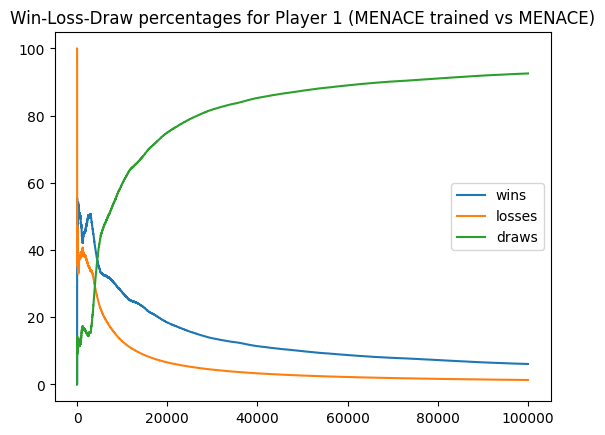

In [12]:
results1 = game1.train_results[0]
wins1, draws1, losses1, tot1 = 0., 0., 0., 0.
fracs1 = [[], [], []]
for i in range(NUM_EPOCHS):
  tot1 += 1
  if results1[i] == 1: wins1 += 1
  elif results1[i] == 0: draws1 += 1
  else: losses1 += 1

  fracs1[0].append((wins1/tot1)*100)
  fracs1[1].append((losses1/tot1)*100)
  fracs1[2].append((draws1/tot1)*100)

plt.plot(range(NUM_EPOCHS), fracs1[0], label = 'wins')
plt.plot(range(NUM_EPOCHS), fracs1[1], label = 'losses')
plt.plot(range(NUM_EPOCHS), fracs1[2], label = 'draws')
plt.title('Win-Loss-Draw percentages for Player 1 (MENACE trained vs MENACE)')
plt.legend()
plt.show()

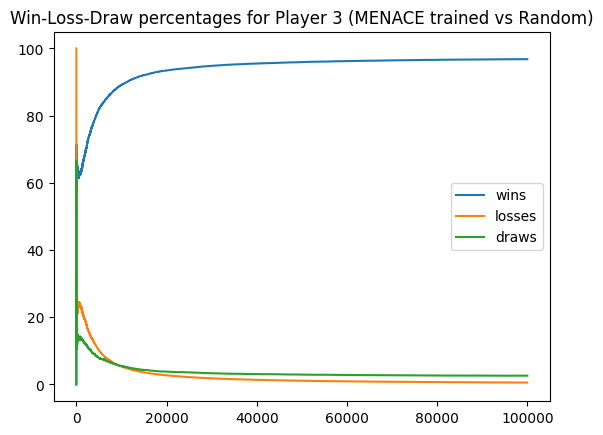

In [13]:
results2 = game2.train_results[0]
wins2, draws2, losses2, tot2 = 0., 0., 0., 0.
fracs2 = [[], [], []]
for i in range(NUM_EPOCHS):
  tot2 += 1
  if results2[i] == 1: wins2 += 1
  elif results2[i] == 0: draws2 += 1
  else: losses2 += 1

  fracs2[0].append((wins2/tot2)*100)
  fracs2[1].append((losses2/tot2)*100)
  fracs2[2].append((draws2/tot2)*100)

plt.plot(range(NUM_EPOCHS), fracs2[0], label = 'wins')
plt.plot(range(NUM_EPOCHS), fracs2[1], label = 'losses')
plt.plot(range(NUM_EPOCHS), fracs2[2], label = 'draws')
plt.title('Win-Loss-Draw percentages for Player 3 (MENACE trained vs Random)')
plt.legend()
plt.show()

In [14]:
# GAME 3: Play against player 1 (MENACE trained vs MENACE)
# See if you can beat this policy!

game3 = Game(env, player1, HumanPolicy(symbol=-1))
game3.play()

result = env.winner
print(f"winner: {result}")

player1_reward_map = {'player1': 1, 'player2': -1, 'draw': 0}
player1.update_values(player1_reward_map[result], show_update=True)

-------------
| o |   | x | 
-------------
|   | x | x | 
-------------
|   |   | o | 
-------------
Input your position: a
winner: player1
Player with symbol 1 updates the following history with 1 stone
-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
| o |   | x | 
-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
-------------
| o |   | x | 
-------------
|   | x | x | 
-------------
|   |   | o | 
-------------
-------------
| o |   | x | 
-------------
| o | x | x | 
-------------
| x |   | o | 
-------------


#### Question

What can you infer from the above series of experiments?

**ENTER ANSWER HERE**

1. While MENACE plays against itself, the number of draws increases with increasing training epochs and wins keep going down.
2. However, while playing with the Random Policy algorithm the MENACE player is able to outperform the opponent resulting in more wins and lesser draws with increasing epochs.
3. Playing against a trained MENACE player, even the best a human can hope for is a draw.